1️⃣ 타겟(churn) 생성  
2️⃣ 결측치 확인  
3️⃣ 컬럼 성격별 결측치 처리  
➡️ 3.5 EDA (분포, 상관관계 ⭐)  
4️⃣ 이상치 처리 / log 변환 / 스케일링  
5️⃣ train / test split  
6️⃣ 모델링  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from copy import deepcopy

# 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 경고메시지 숨김용
import warnings
warnings.filterwarnings('ignore')

| 컬럼명(한글) | 컬럼명(영어) | 설명 | 분포(실제 분포) |
|---|---|---|---|
| 게임 ID | appid | Steam 게임 고유 ID | 440 ~ 3,241,660 (mean≈1,239,968) |
| 리뷰 추천 ID | recommendationid | 리뷰 고유 식별자 | 약 1.99e8 ~ 2.15e8 |
| 유저 Steam ID | steamid | 리뷰 작성자 Steam ID | 거의 단일값, 분산 매우 작음 |
| 보유 게임 수 | num_games_owned | 유저가 보유한 전체 게임 수 | 0 ~ 7,706 (median 0, mean 55.9) |
| 작성 리뷰 수 | num_reviews_author | 유저가 작성한 전체 리뷰 수 | 1 ~ 2,542 (median 3) |
| 누적 플레이 타임 | playtime_forever | 해당 게임 총 플레이 시간 | 5 ~ 1,457,369 |
| 최근 2주 플레이 타임 | playtime_last_two_weeks | 최근 2주간 플레이 시간 | 0 ~ 17,144 (75% ≤ 370) |
| 리뷰 시점 플레이 타임 | playtime_at_review | 리뷰 작성 시점 누적 플레이 시간 | 5 ~ 1,396,679 |
| Steam Deck 플레이 타임 | deck_playtime_at_review | 리뷰 시점 Steam Deck 플레이 시간 | 1 ~ 51,724 (표본 적음) |
| 마지막 플레이 시각 | last_played | 마지막 플레이 시점 (Unix) | 1.47e9 ~ 1.77e9 |
| 리뷰 생성 시각 | timestamp_created | 리뷰 최초 작성 시각 (Unix) | 1.75e9 ~ 1.77e9 |
| 리뷰 수정 시각 | timestamp_updated | 리뷰 최종 수정 시각 (Unix) | 생성 시각과 거의 동일 |
| 긍정 추천 여부 | voted_up | 긍정 리뷰 여부 (1=긍정) | mean 0.633 (긍정 약 63%) |
| 도움됨 투표 수 | votes_up | 도움이 됐다고 평가한 수 | 0 ~ 1,511 (대부분 0) |
| 재미있음 투표 수 | votes_funny | 재미있다고 평가한 수 | 0 ~ 438 (대부분 0) |
| 가중 투표 점수 | weighted_vote_score | Steam 내부 도움도 점수 | 0.29 ~ 0.95 (median 0.5) |
| 댓글 수 | comment_count | 리뷰에 달린 댓글 수 | 0 ~ 14 (99% 이상 0) |
| 개발자 응답 시각 | timestamp_dev_responded | 개발자 답변 시각 (Unix) | 존재 데이터 56건 |
| Steam 구매 여부 | steam_purchase | Steam에서 구매했는지 여부 | 없음 |
| 무료 획득 여부 | received_for_free | 무료로 받았는지 여부 | 없음 |
| 얼리액세스 작성 여부 | written_during_early_access | 얼리액세스 중 작성 여부 | 없음 |
| 리뷰 언어 | language | 리뷰 작성 언어 | 없음 |
| 리뷰 텍스트 | review | 리뷰 본문 텍스트 | 없음 |
| 개발자 응답 내용 | developer_response | 개발자 답변 텍스트 | 없음 |
| Steam Deck 주 사용 여부 | primarily_steam_deck | Steam Deck 위주 플레이 여부 | 없음 |
| 중복 appid | appid_1 | appid 중복 컬럼 | appid와 동일 |
| 난수 컬럼 | rnd | 무작위 샘플링용 컬럼 | 0 ~ 0.019 |
|---|---|---|---|
| 이탈 여부 | churn |  |  |



* 현재 기준으로는 모든 사람들이 이탈했다고 예측할 가능성이 있어 
기준일을 리뷰 최종 수정시각으로 정해서 기준일 전후로 이탈 여부 알아보기

- 기준일 : timestamp_updated(리뷰 최종 수정 시각)
- 이탈(1) : timestamp_updated - author.last_played >= 30일 (기준일 - 마지막 게임 시각 >= 30일)
- 비이탈(0) : timestamp_updated - author.last_played < 30일 (기준일 - 마지막 게임 시각 < 30일) 

In [2]:
df = pd.read_csv('./data/reviews_joined_all_matched.csv')
df

,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,deck_playtime_at_review,last_played,...,comment_count,steam_purchase,received_for_free,written_during_early_access,developer_response,timestamp_dev_responded,primarily_steam_deck,appid_1,game_name,genre
0,2139460,199685023,76561198220582271,23,1,15240.0,0.0,15240,NaN,1.748034e+09,...,1,False,False,False,NaN,NaN,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '..."
1,2139460,199684668,76561198401253542,0,1,6249.0,0.0,834,NaN,1.755746e+09,...,0,False,False,False,NaN,NaN,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '..."
2,2139460,199683985,76561199435851437,0,1,20522.0,0.0,12327,NaN,1.755124e+09,...,0,False,False,False,NaN,NaN,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '..."
3,2139460,199683578,76561198977144059,83,30,22726.0,0.0,4090,NaN,1.755366e+09,...,0,False,False,False,NaN,NaN,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '..."
4,2139460,199683575,76561199109403538,0,1,2747.0,0.0,2389,NaN,1.752985e+09,...,0,False,False,False,NaN,NaN,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030651,526870,215146158,76561198022734436,95,4,13884.0,645.0,13238,NaN,1.767635e+09,...,0,False,False,False,NaN,NaN,False,526870,Satisfactory,"['Adventure', 'Indie', 'Simulation', 'Strategy']"
1030652,526870,215145064,76561199525731410,0,3,4075.0,4075.0,3547,NaN,1.767588e+09,...,0,True,False,False,NaN,NaN,False,526870,Satisfactory,"['Adventure', 'Indie', 'Simulation', 'Strategy']"
1030653,526870,215144030,76561199864838845,0,3,467.0,467.0,364,NaN,1.767635e+09,...,0,True,False,False,NaN,NaN,False,526870,Satisfactory,"['Adventure', 'Indie', 'Simulation', 'Strategy']"
1030654,526870,215143393,76561199698303694,0,1,8166.0,946.0,8166,NaN,1.767463e+09,...,0,True,False,False,NaN,NaN,False,526870,Satisfactory,"['Adventure', 'Indie', 'Simulation', 'Strategy']"


In [3]:
review_dt = pd.to_datetime(df["timestamp_created"], unit="s")
last_dt   = pd.to_datetime(df["last_played"], unit="s")

df["days_after_review"] = (last_dt - review_dt).dt.days

df["churn"] = (df["days_after_review"] < 30).astype(int)

# 예외 처리
df.loc[df["last_played"] == 0, "churn"] = 1
df.loc[df["days_after_review"] < 0, "churn"] = 1

#### 타겟 설정


In [4]:
# churn 여부(0/1)별 데이터 개수 확인
df['churn'].value_counts()

churn
1    612302
0    418354
Name: count, dtype: int64

#### 결측치 확인

In [5]:
df.isnull().sum()

appid                                0
recommendationid                     0
steamid                              0
num_games_owned                      0
num_reviews_author                   0
playtime_forever                    11
playtime_last_two_weeks             11
playtime_at_review                   0
deck_playtime_at_review        1011112
last_played                         11
language                             0
review                            3568
timestamp_created                    0
timestamp_updated                    0
voted_up                             0
votes_up                             0
votes_funny                          0
weighted_vote_score                  0
comment_count                        0
steam_purchase                       0
received_for_free                    0
written_during_early_access          0
developer_response             1027150
timestamp_dev_responded        1027150
primarily_steam_deck                 0
appid_1                  

In [6]:
# 장르처리
# 리스트 안에 장르가 포함되있으면 1, 없으면 0
ending_genre = [
  "Visual Novel",
  "Interactive Fiction",
  "Walking Simulator",
  "Story Rich",
  "Adventure",
  "Puzzle",
  "Horror",
  "Mystery",
  "Psychological Horror",
  "Narrative"
]

df['is_ending_genre'] = df['genre'].apply(
    lambda x : int(isinstance(x, str) and any (g in x for g in ending_genre))
)

df.head()

,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,deck_playtime_at_review,last_played,...,written_during_early_access,developer_response,timestamp_dev_responded,primarily_steam_deck,appid_1,game_name,genre,days_after_review,churn,is_ending_genre
0,2139460,199685023,76561198220582271,23,1,15240.0,0.0,15240,NaN,1.748034e+09,...,False,NaN,NaN,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '...",-51.0,1,1
1,2139460,199684668,76561198401253542,0,1,6249.0,0.0,834,NaN,1.755746e+09,...,False,NaN,NaN,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '...",38.0,0,1
2,2139460,199683985,76561199435851437,0,1,20522.0,0.0,12327,NaN,1.755124e+09,...,False,NaN,NaN,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '...",31.0,0,1
3,2139460,199683578,76561198977144059,83,30,22726.0,0.0,4090,NaN,1.755366e+09,...,False,NaN,NaN,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '...",34.0,0,1
4,2139460,199683575,76561199109403538,0,1,2747.0,0.0,2389,NaN,1.752985e+09,...,False,NaN,NaN,False,2139460,Once Human,"['Action', 'Adventure', 'RPG', 'Simulation', '...",6.0,1,1


In [7]:
import re
import pandas as pd
import numpy as np

# 1) 언어별 키워드 사전
# - phrases: 문장/구문(부분일치 OK)
# - words: 단어성 키워드(라틴권은 단어경계 \b 적용)
# - neg: 부정 구문(걸리면 good=0으로 처리)
# - boundary: words에 \b를 붙일지 여부 (중국어/일본어/태국어/한국어는 보통 False)
LEXICON = {
    # English
    "english": {
        "phrases": [
            r"highly recommend(?:ed)?",
            r"definitely recommend",
            r"worth (?:buying|it|the money|the time)",
            r"great game",
            r"amazing game",
            r"awesome game",
            r"best game(?:s)?",
        ],
        "words": [
            r"awesome", r"amazing", r"great", r"excellent", r"fantastic", r"incredible",
            r"masterpiece", r"perfect", r"love", r"fun", r"enjoy", r"recommend", r"worth",
        ],
        "neg": [
            r"not\s+good", r"not\s+great", r"not\s+worth",
            r"(?:do\s*not|don't|dont)\s+recommend",
            r"(?:do\s*not|don't|dont)\s+buy",
            r"can't\s+recommend|cant\s+recommend",
            r"avoid\b", r"refund\b",
        ],
        "boundary": True,
    },

    # Spanish (Spain) + LatAm는 같이 처리
    "spanish": {
        "phrases": [r"muy bueno", r"vale la pena", r"lo recomiendo", r"recomendad[oa]"],
        "words": [r"genial", r"excelente", r"buen[oa]", r"incre[ií]ble", r"recomiendo", r"recomendar"],
        "neg": [r"no\s+recomiendo", r"no\s+vale\s+la\s+pena", r"no\s+es\s+buen[oa]", r"no\s+merece\s+la\s+pena", r"no\s+compr(?:es|ar)"],
        "boundary": True,
    },
    "latam": {  # 라틴아메리카 스페인어
        "phrases": [r"muy bueno", r"vale la pena", r"lo recomiendo", r"recomendad[oa]"],
        "words": [r"genial", r"excelente", r"buen[oa]", r"incre[ií]ble", r"recomiendo", r"recomendar"],
        "neg": [r"no\s+recomiendo", r"no\s+vale\s+la\s+pena", r"no\s+es\s+buen[oa]", r"no\s+merece\s+la\s+pena", r"no\s+compr(?:es|ar)"],
        "boundary": True,
    },

    # Portuguese (PT / BR)
    "portuguese": {
        "phrases": [r"vale a pena", r"recomendo", r"muito bom", r"jogo (?:muito )?bom"],
        "words": [r"ótimo", r"excelente", r"incr[ií]vel", r"perfeito", r"divertido", r"recomendar"],
        "neg": [r"não\s+recomendo", r"nao\s+recomendo", r"não\s+vale\s+a\s+pena", r"nao\s+vale\s+a\s+pena", r"não\s+é\s+bom", r"nao\s+e\s+bom", r"não\s+compr(?:e|ar)", r"nao\s+compr(?:e|ar)"],
        "boundary": True,
    },
    "brazilian": {  # 브라질 포르투갈어
        "phrases": [r"vale a pena", r"recomendo", r"muito bom", r"jogo (?:muito )?bom"],
        "words": [r"ótimo", r"excelente", r"incr[ií]vel", r"perfeito", r"divertido", r"recomendar"],
        "neg": [r"não\s+recomendo", r"nao\s+recomendo", r"não\s+vale\s+a\s+pena", r"nao\s+vale\s+a\s+pena", r"não\s+é\s+bom", r"nao\s+e\s+bom", r"não\s+compr(?:e|ar)", r"nao\s+compr(?:e|ar)"],
        "boundary": True,
    },

    # German
    "german": {
        "phrases": [r"sehr gut", r"klare(?:s)? empfehlung", r"lohnt sich", r"absolut empfehl"],
        "words": [r"genial", r"toll", r"super", r"großartig", r"exzellent", r"empfehle", r"empfehlenswert"],
        "neg": [r"nicht\s+empfehl", r"lohnt\s+sich\s+nicht", r"nicht\s+gut", r"kau(?:f|ft)\s+nicht", r"kein\s+kauf"],
        "boundary": True,
    },

    # French
    "french": {
        "phrases": [r"je recommande", r"vaut le coup", r"tr[eè]s bon", r"excellent jeu"],
        "words": [r"g[eé]nial", r"excellent", r"super", r"incroyable", r"parfait", r"recommande"],
        "neg": [r"je\s+ne\s+recommande\s+pas", r"ne\s+vaut\s+pas\s+le\s+coup", r"pas\s+bon", r"n['’]achetez\s+pas", r"n['’]ach[eè]te\s+pas"],
        "boundary": True,
    },

    # Italian
    "italian": {
        "phrases": [r"lo consiglio", r"vale la pena", r"molto bello", r"gioco (?:molto )?bello"],
        "words": [r"fantastico", r"ottimo", r"eccellente", r"stupendo", r"divertente", r"consiglio", r"consigliare"],
        "neg": [r"non\s+lo\s+consiglio", r"non\s+vale\s+la\s+pena", r"non\s+[eè]\s+bello", r"non\s+compr(?:are|atelo)"],
        "boundary": True,
    },

    # Dutch
    "dutch": {
        "phrases": [r"zeker aanraden", r"de moeite waard", r"heel goed", r"geweldig spel"],
        "words": [r"geweldig", r"fantastisch", r"super", r"leuk", r"aanraden", r"aanbevelen", r"waarde"],
        "neg": [r"niet\s+aanrad", r"niet\s+de\s+moeite\s+waard", r"niet\s+goed", r"koop\s+niet"],
        "boundary": True,
    },

    # Swedish / Norwegian / Danish / Finnish
    "swedish": {
        "phrases": [r"rekommenderar", r"värt det", r"jättebra", r"riktigt bra"],
        "words": [r"fantastisk", r"grym", r"suverän", r"toppen", r"kul", r"rekommendera", r"värd"],
        "neg": [r"rekommenderar\s+inte", r"inte\s+värt", r"inte\s+bra", r"köp\s+inte"],
        "boundary": True,
    },
    "norwegian": {
        "phrases": [r"anbefaler", r"verdt det", r"kjempebra", r"veldig bra"],
        "words": [r"fantastisk", r"råbra", r"suveren", r"gøy", r"anbefale", r"verdt"],
        "neg": [r"anbefaler\s+ikke", r"ikke\s+verdt", r"ikke\s+bra", r"ikke\s+kjøp"],
        "boundary": True,
    },
    "danish": {
        "phrases": [r"anbefaler", r"v[æa]rd at", r"mega god", r"rigtig god"],
        "words": [r"fantastisk", r"fremragende", r"super", r"sjov", r"anbefale", r"v[æa]rd"],
        "neg": [r"anbefaler\s+ikke", r"ikke\s+v[æa]rd", r"ikke\s+god", r"k[oø]b\s+ikke"],
        "boundary": True,
    },
    "finnish": {
        "phrases": [r"suosittelen", r"todella hyv[äa]", r"sen arvoinen", r"hyv[äa] peli"],
        "words": [r"loistava", r"mahtava", r"erinomainen", r"hauska", r"suositella", r"arvoinen"],
        "neg": [r"en\s+suosittele", r"ei\s+kannata", r"ei\s+hyv[äa]", r"älä\s+osta"],
        "boundary": True,
    },

    # Polish / Czech / Romanian / Hungarian / Bulgarian / Greek / Ukrainian / Russian / Turkish
    "polish": {
        "phrases": [r"polecam", r"warto", r"świetna gra", r"bardzo dobra"],
        "words": [r"świetn[aey]", r"super", r"rewelacyjna", r"doskonała", r"polecić", r"warto"],
        "neg": [r"nie\s+polecam", r"nie\s+warto", r"nie\s+jest\s+dobr", r"nie\s+kupuj"],
        "boundary": True,
    },
    "czech": {
        "phrases": [r"doporu[čc]uji", r"stoj[ií]\s+za\s+to", r"skv[ěe]l[aá]", r"v[ýy]born[aá]"],
        "words": [r"super", r"skv[ěe]l", r"v[ýy]born", r"bav[ií]", r"doporu[čc]it"],
        "neg": [r"nedoporu[čc]uji", r"nestoj[ií]\s+za\s+to", r"nen[ií]\s+dobr", r"nekupuj"],
        "boundary": True,
    },
    "romanian": {
        "phrases": [r"recomand", r"merit[ăa]", r"foarte bun", r"joc (?:foarte )?bun"],
        "words": [r"excelent", r"minunat", r"super", r"recomanda", r"merit"],
        "neg": [r"nu\s+recomand", r"nu\s+merit[ăa]", r"nu\s+e\s+bun", r"nu\s+cump[ăa]ra"],
        "boundary": True,
    },
    "hungarian": {
        "phrases": [r"aj[aá]nlom", r"meg[eé]ri", r"nagyon j[oó]", r"szuper j[aá]t[eé]k"],
        "words": [r"szuper", r"fantasztikus", r"kiv[aá]l[oó]", r"nagyon", r"aj[aá]nlani", r"meg[eé]r"],
        "neg": [r"nem\s+aj[aá]nlom", r"nem\s+[eé]ri\s+meg", r"nem\s+j[oó]", r"ne\s+vedd\s+meg"],
        "boundary": True,
    },
    "bulgarian": {
        "phrases": [r"препоръч", r"много добра", r"страхотна", r"заслужава си"],
        "words": [r"страхот", r"отлич", r"супер", r"препоръч", r"шедьовър"],
        "neg": [r"не\s+препоръч", r"не\s+си\s+струва", r"не\s+е\s+доб", r"не\s+купувай"],
        "boundary": False,  # кир릴은 \b가 애매해서 단순부분일치로
    },
    "greek": {
        "phrases": [r"το\s+προτείν", r"αξίζει", r"πολύ\s+καλ", r"εξαιρετικ"],
        "words": [r"τέλει", r"φοβε", r"εξαιρετικ", r"καταπληκτικ", r"προτείν", r"αξίζ"],
        "neg": [r"δεν\s+προτείν", r"δεν\s+αξίζ", r"δεν\s+είναι\s+καλ", r"μην\s+αγοράσ"],
        "boundary": False,
    },
    "ukrainian": {
        "phrases": [r"рекоменд", r"дуже\s+хорош", r"варто", r"чудов"],
        "words": [r"відмін", r"класн", r"шедевр", r"рекоменд", r"варто"],
        "neg": [r"не\s+рекоменд", r"не\s+варто", r"не\s+хорош", r"не\s+купуй"],
        "boundary": False,
    },
    "russian": {
        "phrases": [r"рекоменд", r"очень\s+хорош", r"стоит", r"шедевр"],
        "words": [r"отлич", r"классн", r"супер", r"шедевр", r"рекоменд", r"стоит"],
        "neg": [r"не\s+рекоменд", r"не\s+стоит", r"плох", r"не\s+покупай", r"не\s+берите"],
        "boundary": False,
    },
    "turkish": {
        "phrases": [r"kesinlikle tavsiye", r"tavsiye ederim", r"çok iyi", r"mükemmel", r"harika"],
        "words": [r"güzel", r"mükemmel", r"harika", r"şahane", r"tavsiye", r"değer"],
        "neg": [r"tavsiye etmem", r"tavsiye etmiyorum", r"iyi değil", r"alma", r"almayın", r"değmez"],
        "boundary": True,
    },

    # Korean / Japanese / Chinese / Arabic / Thai / Vietnamese / Indonesian
    "koreana": {
        "phrases": [r"강추", r"완전 추천", r"강력 추천", r"갓겜", r"명작", r"존잼", r"개꿀잼", r"재밌", r"재미있"],
        "words": [r"추천", r"최고", r"꿀잼", r"재미", r"좋다", r"훌륭", r"완벽", r"감동"],
        "neg": [r"비추", r"추천\s*안", r"추천\s*하지", r"재미없", r"별로", r"최악", r"사지\s*마", r"사지마", r"환불"],
        "boundary": False,
    },
    "japanese": {
        "phrases": [r"おすすめ", r"オススメ", r"最高", r"神ゲー", r"買う価値", r"面白い", r"楽しい"],
        "words": [r"おすすめ", r"最高", r"神", r"面白", r"楽しい", r"良い", r"素晴らしい"],
        "neg": [r"おすすめしない", r"買わない方が", r"つまらない", r"面白くない", r"最悪", r"返品"],
        "boundary": False,
    },
    "schinese": {
        "phrases": [r"强烈推荐", r"非常推荐", r"值得买", r"值得入", r"很值得", r"很好玩", r"神作", r"精品"],
        "words": [r"推荐", r"值得", r"好玩", r"很好", r"优秀", r"完美", r"喜欢"],
        "neg": [r"不推荐", r"不值得", r"不好玩", r"垃圾", r"别买", r"千万别买", r"退款"],
        "boundary": False,
    },
    "tchinese": {
        "phrases": [r"強烈推薦", r"非常推薦", r"值得買", r"值得入", r"很值得", r"很好玩", r"神作", r"精品"],
        "words": [r"推薦", r"值得", r"好玩", r"很好", r"優秀", r"完美", r"喜歡"],
        "neg": [r"不推薦", r"不值得", r"不好玩", r"垃圾", r"別買", r"千萬別買", r"退款"],
        "boundary": False,
    },
    "arabic": {
        "phrases": [r"أنصح", r"ممتاز", r"رائع", r"يستحق", r"لعبة رائعة", r"ممتعة"],
        "words": [r"ممتاز", r"رائع", r"جميل", r"ممتع", r"يستحق", r"أنصح"],
        "neg": [r"لا\s+أنصح", r"لا\s+يستحق", r"سيئ", r"لا\s+تشتري", r"استرجاع"],
        "boundary": False,
    },
    "thai": {
        "phrases": [r"แนะนำ", r"ดีมาก", r"สุดยอด", r"คุ้มค่า", r"สนุกมาก", r"โคตรสนุก"],
        "words": [r"แนะนำ", r"ดี", r"สนุก", r"สุดยอด", r"คุ้ม", r"ชอบ"],
        "neg": [r"ไม่แนะนำ", r"ไม่คุ้ม", r"ไม่ดี", r"แย่", r"อย่าซื้อ", r"ขอคืนเงิน"],
        "boundary": False,
    },
    "vietnamese": {
        "phrases": [r"rất hay", r"tuyệt vời", r"đáng mua", r"đáng tiền", r"nên mua", r"khuyên dùng"],
        "words": [r"hay", r"tuyệt", r"xuất sắc", r"đáng", r"thích", r"khuyên", r"nên"],
        "neg": [r"không\s+khuyên", r"không\s+đáng", r"đừng\s+mua", r"tệ", r"chán", r"hoàn tiền"],
        "boundary": True,
    },
    "indonesian": {
        "phrases": [r"sangat bagus", r"rekomendasi", r"worth it", r"layak dibeli", r"seru banget"],
        "words": [r"bagus", r"keren", r"mantap", r"seru", r"rekomend", r"layak"],
        "neg": [r"tidak\s+rekomend", r"jangan\s+beli", r"tidak\s+layak", r"jelek", r"buruk", r"refund"],
        "boundary": True,
    },
}

# 없는 언어는 english로 fallback
DEFAULT_LANG = "english"


# 2) 정규식 빌더
def _compile_lexicon(cfg):
    # 언어 별 \b(단어경계)를 쓸지 말지 결정
    # 예를 들어 라틴 알파벳 계열은 단어 \b를 써야 bad가 badly 단어에 붙어서 오탐나는거 방지
    boundary = cfg.get("boundary", True)

    parts_good = []
    for p in cfg.get("phrases", []):
        parts_good.append(f"(?:{p})") # ?:...를 사용하는 이유: 정규식에서 ...은 캡처를 만들고, 매칭 결과에 그룹이 저장.
                                      # ?:...은 그룹화는 하지만 캡처는 안함
    for w in cfg.get("words", []):    # 저희는 or(|)로 묶어서 패턴을 합치는 목적이라서 캡처가 필요없습니다
        if boundary:
            parts_good.append(rf"\b{w}\b")
        else:
            parts_good.append(f"(?:{w})")

    good_pat = "|".join(parts_good) if parts_good else r"$^"  #  r"$^"구문은 비어있을 때 매칭 안 되게 막아주는 역할
    good_re = re.compile(good_pat, flags=re.UNICODE) # 비라틴 문자(한글/중국어/키릴 등) 섞여도 정규식 엔진이 유니코드로 처리

    neg_parts = [f"(?:{p})" for p in cfg.get("neg", [])]
    neg_pat = "|".join(neg_parts) if neg_parts else r"$^"
    neg_re = re.compile(neg_pat, flags=re.UNICODE)

    return good_re, neg_re


# 미리 컴파일 -> 언어별로 딱 한 번만 컴파일 해두고 재사용하는 방식
# 데이터가 100만행 단위일 땐, 행마다 컴파일 성능이 크게 떨어지기 때문
_COMPILED = {}
for lang, cfg in LEXICON.items():
    _COMPILED[lang] = _compile_lexicon(cfg)
_COMPILED[DEFAULT_LANG] = _COMPILED.get(DEFAULT_LANG, _compile_lexicon(LEXICON["english"]))


# 3) 멀티언어 good_review 생성 함수
def add_good_flag_multilang(df, text_col="review", lang_col="language"):
    out = df.copy() # 원본 df 망가뜨리지 않기 위해 복사본에서 작업

    # casefold: lower보다 더 강한 소문자화(터키어 등)
    text = out[text_col].fillna("").astype(str).str.casefold()
    lang = out[lang_col].fillna(DEFAULT_LANG).astype(str)

    good_hit = pd.Series(False, index=out.index) # False 선언: 언어 없는 행이나, 처리 하지 못하는 언어는 안전하게 기본값으로 남기기
    neg_hit  = pd.Series(False, index=out.index)

    # 언어별 반복문을 행 단위가 아니라 언어 단위로 돌아야함
    # 예를 들어 100만행을 100만번 도는 방식은 너무 느리기 때문에 언어 종류 수만큼만 반복실행 (예:30개)
    for l in lang.unique():
        mask = (lang == l)
        # 리뷰로 남겨진 언어가 language쪽에 존재하지 않는다면 default로 영어 정규식 사용
        # 그래서 언어 코드가 예상과 달라도 에러 발생X
        good_re, neg_re = _COMPILED.get(l, _COMPILED[DEFAULT_LANG])

        # 각 리뷰에서 good_re 패턴이 한번이라도 매칭되면 True
        good_hit.loc[mask] = text.loc[mask].str.contains(good_re, regex=True)
        neg_hit.loc[mask]  = text.loc[mask].str.contains(neg_re,  regex=True)

    # 최종 라벨 생성
    # good 조건을 만족하더라도 neg 조건이 잡히면 good리뷰로 보지 않고 탈락시키는 구문
    out["good_review"] = (good_hit & (~neg_hit)).astype(int)
    return out


# 4) 적용
# temp 데이터프레임에 대해 생성
# 결과로 good_review가 추가된 df 반환
# 분포 확인은 라벨이 너무 한쪽으로 쏠리는 지 출력으로 확인
df_good = add_good_flag_multilang(df, text_col="review", lang_col="language")
print(df_good["good_review"].value_counts())


good_review
0    754224
1    276432
Name: count, dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030656 entries, 0 to 1030655
Data columns (total 31 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   appid                        1030656 non-null  int64  
 1   recommendationid             1030656 non-null  int64  
 2   steamid                      1030656 non-null  int64  
 3   num_games_owned              1030656 non-null  int64  
 4   num_reviews_author           1030656 non-null  int64  
 5   playtime_forever             1030645 non-null  float64
 6   playtime_last_two_weeks      1030645 non-null  float64
 7   playtime_at_review           1030656 non-null  int64  
 8   deck_playtime_at_review      19544 non-null    float64
 9   last_played                  1030645 non-null  float64
 10  language                     1030656 non-null  object 
 11  review                       1027088 non-null  object 
 12  timestamp_created            1030656 non-n

In [9]:
# 결측치 처리
# deck_playtime_at_review, review , developer_response, timestamp_dev_responded, genre, game_name: 모두 삭제
df = df.drop(columns=['deck_playtime_at_review', 'review', 'developer_response', 'timestamp_dev_responded','genre', 'game_name'])

# 수치형 컬럼 : 중앙값
df['playtime_forever'] = df['playtime_forever'].fillna(df['playtime_forever'].median())
df['playtime_last_two_weeks'] = df['playtime_last_two_weeks'].fillna(df['playtime_last_two_weeks'].median())
df['last_played'] = df['last_played'].fillna(df['last_played'].median())
df['days_after_review'] = df['days_after_review'].fillna(df['days_after_review'].median())


df.head()

,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,language,...,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,primarily_steam_deck,appid_1,days_after_review,churn,is_ending_genre
0,2139460,199685023,76561198220582271,23,1,15240.0,0.0,15240,1.748034e+09,turkish,...,0.712445,1,False,False,False,False,2139460,-51.0,1,1
1,2139460,199684668,76561198401253542,0,1,6249.0,0.0,834,1.755746e+09,spanish,...,0.500000,0,False,False,False,False,2139460,38.0,0,1
2,2139460,199683985,76561199435851437,0,1,20522.0,0.0,12327,1.755124e+09,english,...,0.500000,0,False,False,False,False,2139460,31.0,0,1
3,2139460,199683578,76561198977144059,83,30,22726.0,0.0,4090,1.755366e+09,english,...,0.500000,0,False,False,False,False,2139460,34.0,0,1
4,2139460,199683575,76561199109403538,0,1,2747.0,0.0,2389,1.752985e+09,schinese,...,0.500000,0,False,False,False,False,2139460,6.0,1,1


In [10]:
df.isnull().sum()

appid                          0
recommendationid               0
steamid                        0
num_games_owned                0
num_reviews_author             0
playtime_forever               0
playtime_last_two_weeks        0
playtime_at_review             0
last_played                    0
language                       0
timestamp_created              0
timestamp_updated              0
voted_up                       0
votes_up                       0
votes_funny                    0
weighted_vote_score            0
comment_count                  0
steam_purchase                 0
received_for_free              0
written_during_early_access    0
primarily_steam_deck           0
appid_1                        0
days_after_review              0
churn                          0
is_ending_genre                0
dtype: int64

In [11]:
df.describe()

,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,timestamp_created,timestamp_updated,votes_up,votes_funny,weighted_vote_score,comment_count,appid_1,days_after_review,churn,is_ending_genre
count,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06,1.030656e+06
mean,1.246007e+06,2.078202e+08,7.656120e+16,5.589029e+01,9.407134e+00,1.421302e+04,4.750092e+02,1.179464e+04,1.762457e+09,1.760941e+09,1.761054e+09,6.485481e-01,1.244169e-01,5.027320e-01,4.645294e-02,1.246007e+06,1.705670e+01,5.940896e-01,5.113297e-01
std,8.606580e+05,4.897537e+06,6.086190e+08,1.973416e+02,6.927022e+01,3.357508e+04,1.155315e+03,3.145326e+04,1.173881e+07,4.747926e+06,4.725906e+06,1.345458e+01,3.082606e+00,2.275669e-02,6.260744e-01,8.606580e+05,1.374151e+02,4.910676e-01,4.998719e-01
min,4.400000e+02,1.994023e+08,7.656120e+16,0.000000e+00,1.000000e+00,5.000000e+00,0.000000e+00,5.000000e+00,1.345532e+09,1.752096e+09,1.752096e+09,0.000000e+00,0.000000e+00,1.352486e-01,0.000000e+00,4.400000e+02,-4.763000e+03,0.000000e+00,0.000000e+00
25%,5.268700e+05,2.032641e+08,7.656120e+16,0.000000e+00,1.000000e+00,1.440000e+03,0.000000e+00,8.080000e+02,1.761593e+09,1.756657e+09,1.756828e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,5.268700e+05,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.172470e+06,2.081491e+08,7.656120e+16,0.000000e+00,3.000000e+00,4.408000e+03,0.000000e+00,2.723000e+03,1.765687e+09,1.762017e+09,1.762260e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.172470e+06,1.700000e+01,1.000000e+00,1.000000e+00
75%,1.771300e+06,2.122663e+08,7.656120e+16,5.100000e+01,8.000000e+00,1.229500e+04,3.620000e+02,9.001000e+03,1.767210e+09,1.764576e+09,1.764617e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.771300e+06,6.200000e+01,1.000000e+00,1.000000e+00
max,3.241660e+06,2.152632e+08,7.656120e+16,3.370000e+04,1.974800e+04,2.457680e+06,3.460800e+04,2.416117e+06,1.767652e+09,1.767650e+09,1.767651e+09,5.763000e+03,1.425000e+03,9.897801e-01,2.580000e+02,3.241660e+06,1.790000e+02,1.000000e+00,1.000000e+00


#### 컬럼 정리

In [12]:
# 안쓰는 컬럼 제거
id_cols = [
    'recommendationid',
    'steamid',
    'appid_1',
    'rnd',
    'language'
]

id_cols = [c for c in id_cols if c in df.columns]

df = df.drop(columns=id_cols)
df.head()

,appid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,timestamp_created,timestamp_updated,voted_up,...,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,primarily_steam_deck,days_after_review,churn,is_ending_genre
0,2139460,23,1,15240.0,0.0,15240,1.748034e+09,1752389967,1752389967,False,...,2,0.712445,1,False,False,False,False,-51.0,1,1
1,2139460,0,1,6249.0,0.0,834,1.755746e+09,1752389691,1752389691,True,...,0,0.500000,0,False,False,False,False,38.0,0,1
2,2139460,0,1,20522.0,0.0,12327,1.755124e+09,1752389204,1752389204,True,...,0,0.500000,0,False,False,False,False,31.0,0,1
3,2139460,83,30,22726.0,0.0,4090,1.755366e+09,1752388914,1752388914,True,...,0,0.500000,0,False,False,False,False,34.0,0,1
4,2139460,0,1,2747.0,0.0,2389,1.752985e+09,1752388911,1752388911,True,...,0,0.500000,0,False,False,False,False,6.0,1,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030656 entries, 0 to 1030655
Data columns (total 21 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   appid                        1030656 non-null  int64  
 1   num_games_owned              1030656 non-null  int64  
 2   num_reviews_author           1030656 non-null  int64  
 3   playtime_forever             1030656 non-null  float64
 4   playtime_last_two_weeks      1030656 non-null  float64
 5   playtime_at_review           1030656 non-null  int64  
 6   last_played                  1030656 non-null  float64
 7   timestamp_created            1030656 non-null  int64  
 8   timestamp_updated            1030656 non-null  int64  
 9   voted_up                     1030656 non-null  bool   
 10  votes_up                     1030656 non-null  int64  
 11  votes_funny                  1030656 non-null  int64  
 12  weighted_vote_score          1030656 non-n

#### 파생변수 생성

In [14]:
# 플레이 강도
df["play_intensity"] = df["playtime_at_review"] / (df["num_games_owned"] + 1)

# 최근 활동성
df["recent_ratio"] = df["playtime_last_two_weeks"] / (df["playtime_forever"] + 1)

# 리뷰 시점 몰입도
df["review_commitment"] = df["playtime_at_review"] / (df["playtime_forever"] + 1)

# 리뷰-업데이트 간격 (수정안함->즉흥단발성 / 수정함 -> 관심지속)
df["edit_delay"] = (df["timestamp_updated"] - df["timestamp_created"]) / 86400

# 유저 성향 / 리뷰 경험치
df["review_experience"] = np.log1p(df["num_reviews_author"])

# 유저 성향 / 게임 소유 대비 리뷰 비율 (게임소비방식)
df["review_ratio"] = df["num_reviews_author"] / (df["num_games_owned"] + 1)

# 리뷰 이후 플레이 지속일수
df["post_review_days"] = df["days_after_review"].clip(lower=0)

# 리뷰 이후 즉시 이탈 여부
df["quit_immediately"] = (df["days_after_review"] <= 1).astype(int)

# 리뷰 후 플레이 존재 여부
df["played_after_review"] = (df["days_after_review"] > 0).astype(int)

# 리뷰 시점 몰입 대비 이후 지속력
df["review_to_post_ratio"] = df["days_after_review"] / (df["playtime_at_review"] + 1)

# 최근 활동 완전 단절 여부
df["no_recent_play"] = (df["playtime_last_two_weeks"] == 0).astype(int)

# 플레이 감소 강도
df["play_drop_ratio"] = 1 - (
    df["playtime_last_two_weeks"] / (df["playtime_at_review"] + 1)
)

# 리뷰 수정 행동 여부
df["edited_review"] = (df["timestamp_updated"] > df["timestamp_created"]).astype(int)

# 리뷰 영향력 대비 이탈
df["review_engagement"] = np.log1p(
    df["votes_up"] + df["votes_funny"] + df["comment_count"]
)

# 유저 게임 소비 성향
df["game_focus_ratio"] = df["playtime_forever"] / (df["num_games_owned"] + 1)


In [15]:
df.isnull().sum().sort_values(ascending=False).head(10)

appid                      0
num_games_owned            0
num_reviews_author         0
playtime_forever           0
playtime_last_two_weeks    0
playtime_at_review         0
last_played                0
timestamp_created          0
timestamp_updated          0
voted_up                   0
dtype: int64

#### 상관관계 확인

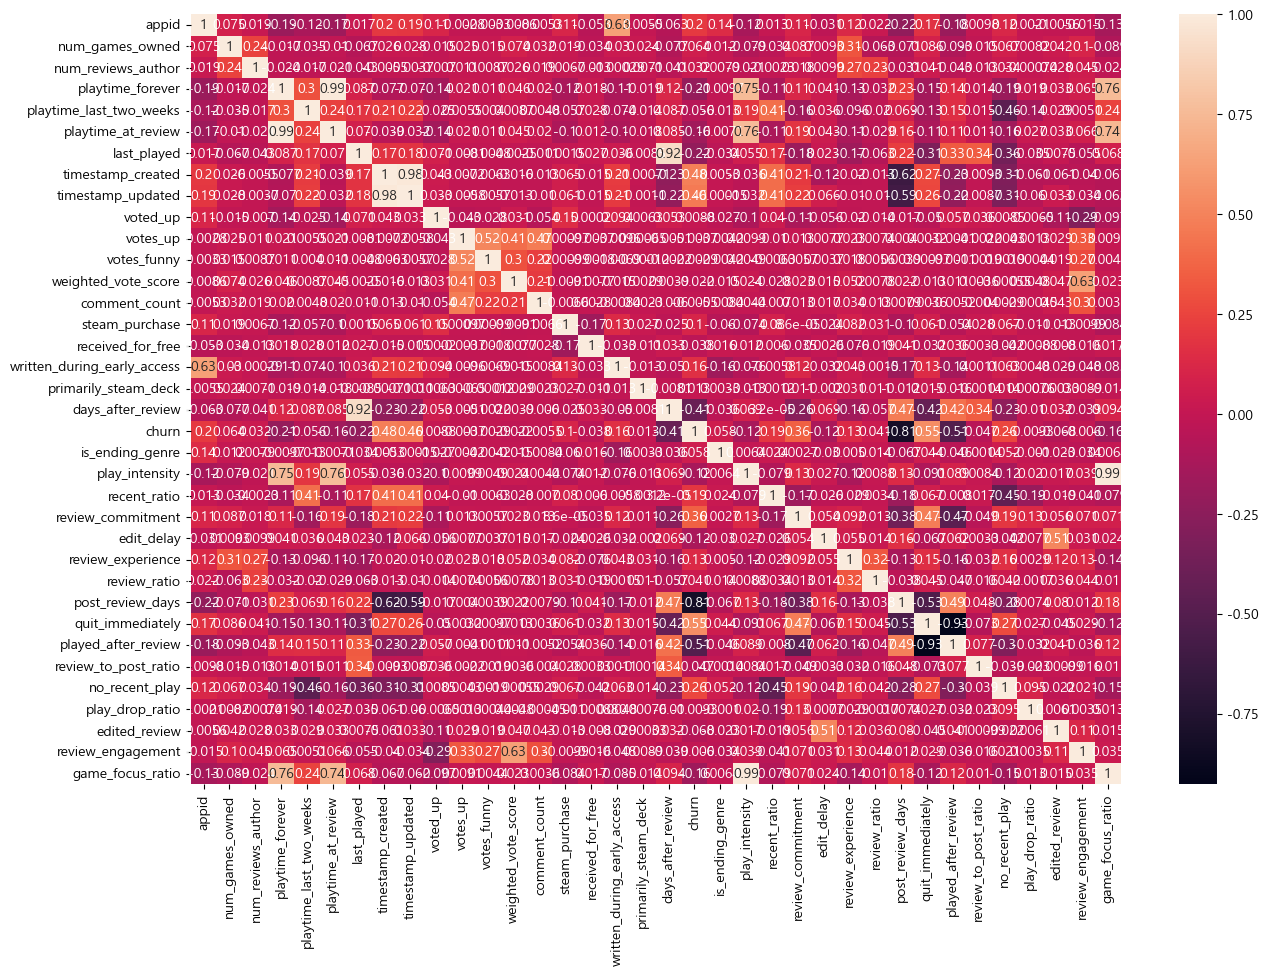

In [16]:
# num, bool type 상관관계 히트맵으로 확인하기
nb_type = df.select_dtypes(include=['int64', 'float64', 'bool'])

corr_nb = nb_type.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(data=corr_nb, annot=True)
plt.show()


컬럼이 많아 히트맵으로 확인하기 어려워, 이탈(churn)과의 상관계수만 추출

In [17]:
# churn_dt와의 상관관계 
nb_type = df.select_dtypes(include=['int64', 'float64', 'bool'])
corr_nb = nb_type.corr()['churn'].sort_values(ascending=False)

corr_nb

churn                          1.000000
quit_immediately               0.545455
timestamp_created              0.481932
timestamp_updated              0.462448
review_commitment              0.357050
no_recent_play                 0.259883
appid                          0.204305
recent_ratio                   0.190399
written_during_early_access    0.162435
review_experience              0.129916
steam_purchase                 0.102510
num_games_owned                0.063580
is_ending_genre                0.058384
review_ratio                   0.040576
num_reviews_author             0.032201
primarily_steam_deck           0.013092
voted_up                       0.008802
votes_funny                   -0.002863
votes_up                      -0.003701
comment_count                 -0.005549
review_engagement             -0.005968
play_drop_ratio               -0.009251
weighted_vote_score           -0.021504
received_for_free             -0.038065
review_to_post_ratio          -0.046957


timestamp_created(리뷰 생성 시각)과 timestamp_updated(리뷰 수정 시각) 두 컬럼이 churn(이탈 여부)와 높은 상관관계를 보였다.

#### log 변환
- 한쪽으로 쏠린 데이터를 고르게 펴주고, 너무 큰 숫자의 튀는 효과를 줄여 모델을 안정시키기 위해 변환함

In [18]:
log_cols = [
    'num_games_owned',
    'num_reviews_author',
    'playtime_forever',
    'playtime_last_two_weeks',
    'playtime_at_review',
    'votes_up',
    'votes_funny',
    'comment_count'
]

# df_log = deepcopy(df)
df[log_cols] = df[log_cols].apply(np.log1p)

df

,appid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,timestamp_created,timestamp_updated,voted_up,...,review_ratio,post_review_days,quit_immediately,played_after_review,review_to_post_ratio,no_recent_play,play_drop_ratio,edited_review,review_engagement,game_focus_ratio
0,2139460,3.178054,0.693147,9.631744,0.000000,9.631744,1.748034e+09,1752389967,1752389967,False,...,0.041667,0.0,1,0,-0.003346,1,1.000000,0,3.044522,635.000000
1,2139460,0.000000,0.693147,8.740337,0.000000,6.727432,1.755746e+09,1752389691,1752389691,True,...,1.000000,38.0,0,1,0.045509,1,1.000000,0,0.000000,6249.000000
2,2139460,0.000000,0.693147,9.929301,0.000000,9.419628,1.755124e+09,1752389204,1752389204,True,...,1.000000,31.0,0,1,0.002515,1,1.000000,0,0.000000,20522.000000
3,2139460,4.430817,3.433987,10.031309,0.000000,8.316545,1.755366e+09,1752388914,1752388914,True,...,0.357143,34.0,0,1,0.008311,1,1.000000,0,0.000000,270.547619
4,2139460,0.000000,0.693147,7.918629,0.000000,7.779049,1.752985e+09,1752388911,1752388911,True,...,1.000000,6.0,0,1,0.002510,1,1.000000,0,0.000000,2747.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030651,526870,4.564348,1.609438,9.538564,6.470800,9.490922,1.767635e+09,1767549535,1767549535,True,...,0.041667,0.0,1,0,0.000000,0,0.951280,0,0.000000,144.625000
1030652,526870,0.000000,1.386294,8.312871,8.312871,8.174139,1.767588e+09,1767548829,1767548829,True,...,3.000000,0.0,1,0,0.000000,0,-0.148534,0,0.000000,4075.000000
1030653,526870,0.000000,1.386294,6.148468,6.148468,5.899897,1.767635e+09,1767548108,1767548108,True,...,3.000000,1.0,1,1,0.002740,0,-0.279452,0,0.000000,467.000000
1030654,526870,0.000000,0.693147,9.007857,6.853299,9.007857,1.767463e+09,1767547704,1767547704,True,...,1.000000,0.0,1,0,-0.000122,0,0.884168,0,0.000000,8166.000000


#### 데이터 분리

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

정답을 알 수 있는 컬럼 제외하여 X 만들기
- playtime_forever
- playtime_last_two_weeks
- playtime_at_review
- last_played
- timestamp_created
- timestamp_updated


In [20]:
df.columns

Index(['appid', 'num_games_owned', 'num_reviews_author', 'playtime_forever',
       'playtime_last_two_weeks', 'playtime_at_review', 'last_played',
       'timestamp_created', 'timestamp_updated', 'voted_up', 'votes_up',
       'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase',
       'received_for_free', 'written_during_early_access',
       'primarily_steam_deck', 'days_after_review', 'churn', 'is_ending_genre',
       'play_intensity', 'recent_ratio', 'review_commitment', 'edit_delay',
       'review_experience', 'review_ratio', 'post_review_days',
       'quit_immediately', 'played_after_review', 'review_to_post_ratio',
       'no_recent_play', 'play_drop_ratio', 'edited_review',
       'review_engagement', 'game_focus_ratio'],
      dtype='object')

Recall 강화형 (이탈 최대 탐지: 행동 중심))
- 기존
    - playtime_last_two_weeks → 최근 2주 플레이 타임
    - playtime_at_review → 리뷰 시점 플레이 타임
    - playtime_forever → 누적 플레이 타임
    - num_games_owned → 보유 게임 수

- 파생
    - no_recent_play → 최근 활동 완전 단절 여부(2주 0시간 여부)
    - play_drop_ratio → 플레이 감소 강도(최근/리뷰시점 대비 감소)
    - recent_ratio → 최근 활동성(최근2주/누적)
    - play_intensity → 플레이 강도(리뷰시점 플레이/보유게임수)


In [ ]:
# 데이터 분리
feature_cols = [
    # 기존 컬럼
    'playtime_last_two_weeks',

    'playtime_at_review',

    'playtime_forever',

    'num_games_owned',

    # 파생변수
    'no_recent_play',

    'play_drop_ratio',

    'recent_ratio',

    'play_intensity'
]

X = df[feature_cols]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f'X_train : {len(X_train)}개, X_test : {len(X_test)}개, y_train : {len(y_train)}개, y_test : {len(y_test)}개')

X_train : 824524개, X_test : 206132개, y_train : 824524개, y_test : 206132개


#### StandardScaler
- bool_cols
    - 0 또는 1(True/False)로 이미 변경해둠 => 스케일링을 할 필요가 없음

- num_cols
    - 범위 맞춰주기 => 스케일링 필요

In [36]:
bool_cols = X_train.select_dtypes(include='bool').columns.tolist()
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()

print(f'bool_cols : {len(bool_cols)}, num_cols : {len(num_cols)}')

bool_cols : 0, num_cols : 8


In [37]:
# StandardScaler 객체 생성
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

#### 모델
- RandomForestClassifier / LogisticRegression / LightGBM
- Recall > F1-score(재현율) > Precision(정밀도) > Accuracy(정확도)

In [24]:
!pip install lightgbm

In [38]:
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import (
    accuracy_score,         # 정확도
    precision_score,        # 정밀도
    recall_score,           # 재현율
    f1_score,               # F1 스코어
    classification_report,  # 분류 평가 보고서
    confusion_matrix,       # 혼동행렬 지표
    ConfusionMatrixDisplay  # 혼동행렬시각화
)

In [39]:
# 평가함수 
def evaluate_model(name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # print(f'accuracy_score : {accuracy:.4f}')
    # print(f'precision_score : {precision:.4f}')
    # print(f'recall_score : {recall:.4f}')
    # print(f'f1_score : {f1:.4f}')
    # print(f'confusion_matrix : {cm}')
    print(classification_report(y_test, y_pred, zero_division=0))

In [42]:
# RandomForestClassifier 모델 생성
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth= 12,
    class_weight='balanced',
    random_state=42
)

# 학습 및 예측
rf_model.fit(X_train_scaled, y_train)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, -1]
threshold = 0.5
rf_pred = (rf_proba >= threshold).astype(int)

evaluate_model('RandomForestClassifier', y_test, rf_pred)

              precision    recall  f1-score   support

           0       0.71      0.80      0.75     83671
           1       0.85      0.78      0.81    122461

    accuracy                           0.79    206132
   macro avg       0.78      0.79      0.78    206132
weighted avg       0.79      0.79      0.79    206132



In [40]:
# LogisticRegression 모델 생성
lr_model = LogisticRegression(
    random_state=42
)

lr_model.fit(X_train_scaled, y_train)
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
threshold = 0.5
lr_pred = (lr_proba >= threshold).astype(int)

evaluate_model('LogisticRegression', y_test, lr_pred)

              precision    recall  f1-score   support

           0       0.75      0.67      0.71     83671
           1       0.79      0.85      0.82    122461

    accuracy                           0.78    206132
   macro avg       0.77      0.76      0.76    206132
weighted avg       0.77      0.78      0.77    206132



In [41]:
# LightGBM 모델 생성
lgbm_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth= 12,
    class_weight='balanced',
    random_state=42
)
lgbm_model.fit(X_train_scaled, y_train)
lgb_proba = lgbm_model.predict_proba(X_test_scaled)[:, 1]
threshold = 0.5
lgb_pred = (lgb_proba >= threshold).astype(int)

evaluate_model('LightGBM', y_test, lgb_pred)

[LightGBM] [Info] Number of positive: 489841, number of negative: 334683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1788
[LightGBM] [Info] Number of data points in the train set: 824524, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
              precision    recall  f1-score   support

           0       0.74      0.80      0.77     83671
           1       0.85      0.81      0.83    122461

    accuracy                           0.80    206132
   macro avg       0.80      0.80      0.80    206132
weighted avg       0.81      0.80      0.80    206132

